In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Counting the number of cells in an image
Images of blood cells under microscope are going to be used in this project. Firstly, the images are going to be preprocessed using thresholding in order to segment the images into a background (black color) and foregrand class (white). Once this is done, the next step is to count the number of cells using the connected component algorithm in the binary image.

### Importing libraries

In [3]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Loading the test images from path

In [5]:
def get_imgs_from_path(path, *format_images):
    format_images = list(format_images)
    files = []
    [files.extend(glob.glob(path + '*.' + f)) for f in format_images]
    images = [cv2.imread(file) for file in files]
    return images

images = get_imgs_from_path('images/','jpg')

### Displaying the test images

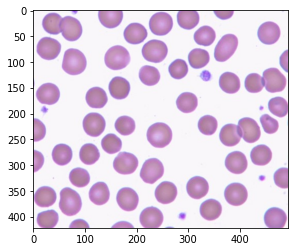

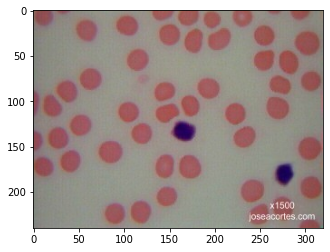

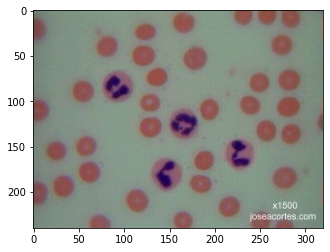

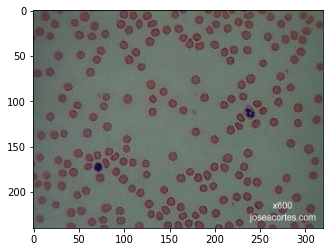

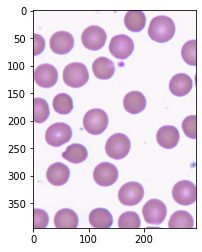

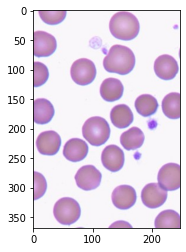

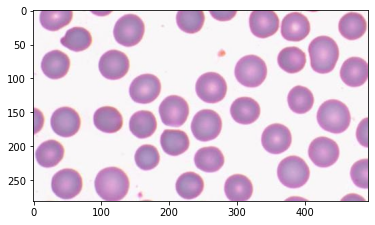

In [7]:
for image in images:
    image_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_display)
    plt.show()

## Image thresholding
This technique is going to be used for segmenting the images. The idea is to segment the image in two classes: the background and the foregrond (cells).
The **Otsu thresholding** algorithm is going to be used in this case. The otsu thresholding can be applied directly from the **cv2 library** using the threshold function, but in this case the function is going to be developed from scratch.
This algorithm exhaustively searches for the threshold that minimizes the intra-class variance, defined as a weighted sum of variances of the two classes:\
**$\sigma^{2}_{w}(t)$ = $w_{0}(t)$$\cdot$$\sigma^{2}_{0}(t)$ $+$ $w_{1}(t)$$\cdot$$\sigma^{2}_{1}(t)$** \
where **$w_{0}(t)$** and **$w_{0}(t)$** are the probabilities of the two classes separated by a threshold **t** ,and **$\sigma^{2}_{0}(t)$** and **$\sigma^{2}_{1}(t)$** are variances of these two classes\
for more info: [Otsu Method](https://en.wikipedia.org/wiki/Otsu%27s_method)

### Functions needed:
For implementing the Otsu threshold, apart from the **otsu** function, the **median_filter** function was developed from scratch for applying it to the images as a pre processing step for removing the noise. Also, the **df_and_histogram_eq** function is needed in order to implement the otsu function.

In [8]:
def median_filter(img,k):
    '''returns the image after applied a median filter with kernel=k and without using padding '''
    kernel = np.full((k,k),1)
    final_row_shape = img.shape[0] - kernel.shape[0] + 1
    final_col_shape = img.shape[1] - kernel.shape[1] + 1
    img_transf = []
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            if row >= final_row_shape:
                continue
            if col >= final_col_shape:
                continue
            else:
                sub_matrix = np.array(img[row:row+kernel.shape[0],col:col+kernel.shape[1]])
                if sub_matrix.shape == kernel.shape:
                    img_transf.append(np.median(sub_matrix))
                else:
                    continue                    
    img_transf = np.array(img_transf).reshape(final_row_shape,final_col_shape)
    return img_transf.astype(np.uint8)

def df_and_histogram_eq(grey_img):
    #code reused from lab1
    '''returns histogram equalization for  a grey img'''
    values, pixels = np.histogram(grey_img.flatten(), bins=range(0,257))
    zipped= zip(pixels,values)
    zipped_list = list(zipped)
    df = pd.DataFrame(zipped_list, columns=['pixel', 'frequency'])
    return df

def otsu(img,kernel=5):
    '''performs an otsu filter using a previous median filter withs kernel=5 as default
    input: img=BGR image, kernel=kernel for the median blur
    returns: img, otsu filtered img with threshold
    '''
    image_display =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #applying the median filter for blurring and the histogram function to get the dataframe of frequency of each pixel
    gray_median = median_filter(gray,kernel) 
    df = df_and_histogram_eq(gray_median)

    ##OTSU THRESHOLD
    #looping the dataframe to get the stats to obtain the optimum threshold
    weights_b = []
    means_b = []
    variances_b = []
    weights_f = []
    means_f = []
    variances_f = []
    for row in range(len(df)):
        if row == 0:
            weights_b.append(0)
            means_b.append(0)
            variances_b.append(0)
            #weights, means, variances
            w_f = round(df.frequency.sum()/df.frequency.sum(),3)
            u_f = round(df.pixel.dot(df.frequency)/df.frequency.sum(),3)
            var_f = df.pixel.apply(lambda x: (x - u_f)**2)
            var_f = round((df.frequency.dot(var_f)).sum()/df.frequency.sum(),3)
            weights_f.append(w_f)
            means_f.append(u_f)
            variances_f.append(var_f)

        else:       
            background = df[0:row]
            #weights, means, variances for the background
            w_b = round(background.frequency.sum()/df.frequency.sum(),3)
            if background.frequency.sum() == 0:
                u_b = 0
                var_b = 0
            else:      
                u_b = round(background.pixel.dot(background.frequency)/background.frequency.sum(),3)
                var_b = background.pixel.apply(lambda x: (x - u_b)**2)
                var_b = round((background.frequency.dot(var_b)).sum()/background.frequency.sum(),3)
            weights_b.append(w_b)
            means_b.append(u_b)
            variances_b.append(var_b)

            foreground = df[row:len(df)]
            #weights, means, variances for the foreground
            w_f = round(foreground.frequency.sum()/df.frequency.sum(),3)
            if foreground.frequency.sum() == 0:
                u_f = 0
                var_f = 0
            else:      
                u_f = round(foreground.pixel.dot(foreground.frequency)/foreground.frequency.sum(),3)
                var_f = foreground.pixel.apply(lambda x: (x - u_f)**2)
                var_f = round((foreground.frequency.dot(var_f)).sum()/foreground.frequency.sum(),3)
            weights_f.append(w_f)
            means_f.append(u_f)
            variances_f.append(var_f)
        #creating the df with all the stats for each threshold (NOT DISPLAYED BUT COULD BE USEFUL)
        df_stats = pd.DataFrame(list(zip(weights_b, means_b,variances_b,weights_f, means_f,variances_f)), columns=['Weight b','Mean b',\
                                                                                                                'Var b', 'Weight f', \
                                                                                                               'Mean f', 'Var f'])
        #adding the within variance column to obtain the minimum value
        df_stats['Within Var'] = df_stats['Weight b']*(df_stats['Var b']) + df_stats['Weight f']*(df_stats['Var f'])
    #minimum threshold
    threshold= df_stats['Within Var'].idxmin()
    #applying the threshold into the image:
    #converting into black and white (boolean)
    otsu_mask = np.array(gray_median < threshold, dtype=np.uint8)


    #ploting the images
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title("Input Image")
    plt.axis('off')
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Otsu's Method, threshold: {}".format(threshold))
    plt.axis('off')    
    ax1.imshow(image_display)
    ax2.imshow(otsu_mask,cmap='gray')  
    return otsu_mask

### Displaying the Otsu threshold applied on the test images:

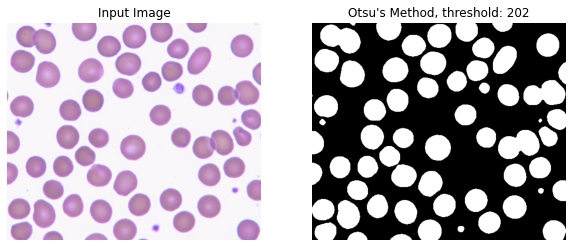

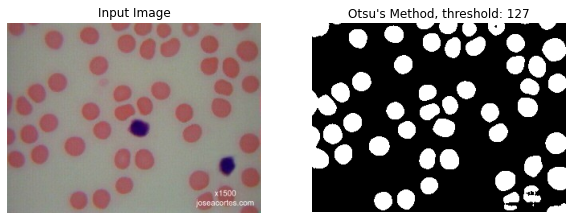

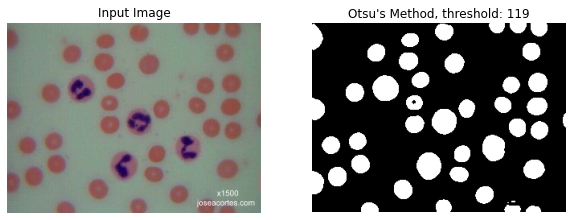

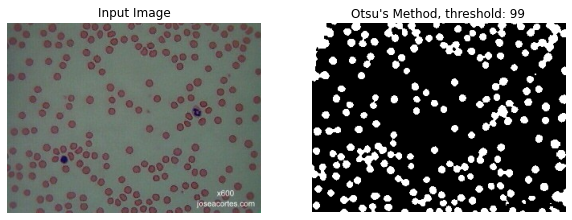

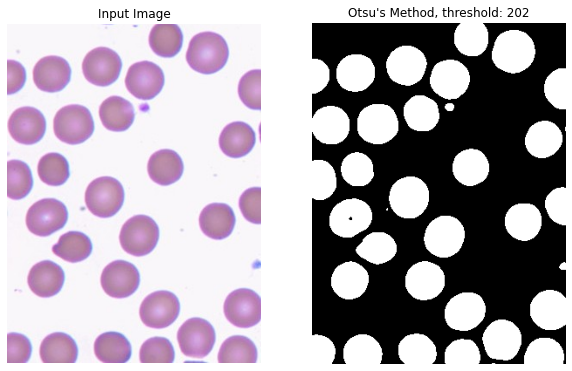

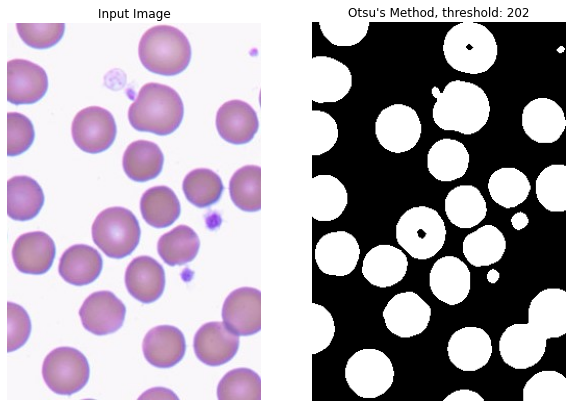

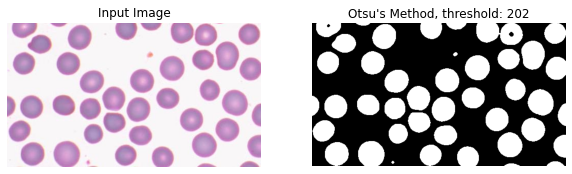

In [11]:
otsu_images = []
for image in images:
    otsu_images.append(otsu(image, kernel=5))

## Counting the cells
After the otsu thresholding is applied, the next step is to use the two-step connected components algorithm to count the number of cells in an image.\
for  more info: [Connected Components Labeling](https://en.wikipedia.org/wiki/Connected-component_labeling)

In [149]:
def count_cells(img):
    '''returns the number of cells in the img, with a stats of the area of the cells and a plot bar of the sizes'''
    img = img.astype(np.int16)
    img_plot = img.copy()
    img[img > 0] = 1000 #aux value, large enough. To activate everything that is background.
    img = np.pad(img, ((1,1),(1,1)), 'constant') #padding the pic with zeros
    equivalence = {} #empty dictionary for the equivalence
    val = 1
    for row in range(img.shape[0]): #looping to creat the first tags for each pixel 
        for col in range(img.shape[1]):
            if img[row,col]: #different from 0
                set_neighbours = set()                
                n1 = img[row+1,col] #neighbours x axis
                n2 = img[row-1,col]                
                n3 = img[row,col+1] #neighbours y axis
                n4 = img[row,col-1]
                ##creating a set of neighbours
                set_neighbours.add(n1)
                set_neighbours.add(n2)
                set_neighbours.add(n3)
                set_neighbours.add(n4)
                set_neighbours = set_neighbours.difference({0,1000})
                if set_neighbours == set():  #no neighbours                       
                    img[row,col] = val
                    val += 1
                    equivalence.update({val:val}) #add to the equivalence list
                    continue             
                else:
                    min_val = min(set_neighbours)
                    max_val = max(set_neighbours)
                    img[row,col] = min_val                   
                    if len(set_neighbours) == 2:
                        if min_val in equivalence.keys():
                            equivalence.update({max_val:equivalence[min_val]}) #adding to the equivalence list with previous key
                        else:
                            equivalence.update({max_val:min_val}) #add to the equivalence list                            
                    continue
                    
    for key, value in equivalence.items(): #updating the equivalence list  
        if value in equivalence.keys():
            equivalence.update({key:equivalence[value]})
                    
    for row in range(img.shape[0]): #udpating the tags, using the equivalence list updated
        for col in range(img.shape[1]):
            if img[row,col] in equivalence.keys():
                img[row,col] = equivalence[img[row,col]]
                
    number_of_cells = len(np.unique(img))-1 #removing the 0 (background)
    sorted_cells = sorted(np.unique(img))[1:] #taking out the 0
    dict_cells = {cell:0 for cell in sorted_cells} #dict for each cell
    
    for row in range(img.shape[0]): #counting to determine the area
            for col in range(img.shape[1]):
                if img[row,col]:
                    dict_cells[img[row,col]] += 1
    
    df = pd.DataFrame.from_dict(dict_cells, orient='index', columns=['Area of cell'])
    df = df.sort_values(by=['Area of cell'])
    
    plot_stats_cells(number_of_cells,df,img_plot=img_plot)
    
    return number_of_cells

def plot_stats_cells(number_of_cells,df,img_plot):
    print('Statistics')
    print(df.describe())
    df.plot.bar(title='Area of Cells',rot=90, figsize=(8,6)) 
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_title("Number of cells: {}".format(number_of_cells))
    ax1.imshow(img_plot)

Statistics
       Area of cell
count     27.000000
mean    1266.629630
std      640.197935
min       39.000000
25%      956.000000
50%     1313.000000
75%     1492.500000
max     2959.000000


27

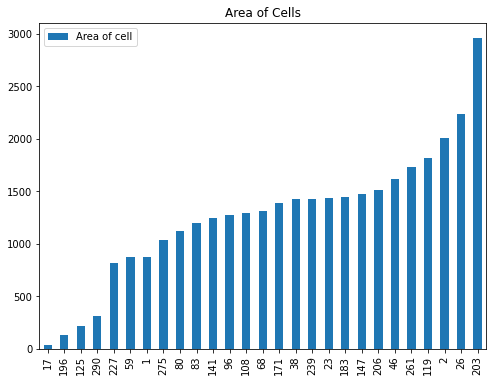

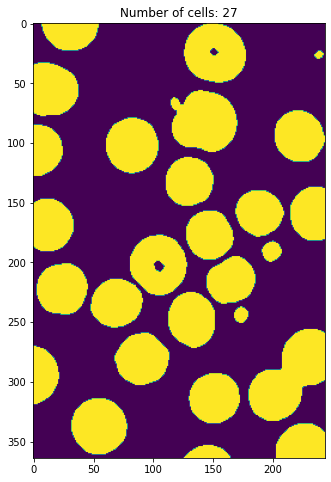

In [153]:
#Example of one image
count_cells(otsu_images[5])

### AGREGAR  MAS BLA BLA
